# Markov chains & Consumption-based asset pricing

## Markov chains

Markov chains are stochastic process which allow us to model interdependence between consecutive observations. For example, if unemployment is high today, it is quite likely that it will remain high tomorrow. We first briefly introduce Markov chains, and the next
section shows how we can use them to model a serially correlated
dividend process and find equilibrium asset prices. Most of the material
in this section is a condensed version of the QuantEcon lectures
[here](https://intro.quantecon.org/markov_chains_I.html)
and
[here](https://intro.quantecon.org/markov_chains_II.html).

### Definition

We first define the following objects:

-   A *state space* $\mathcal{S}$ is finite set of $n$ elements $\mathcal{S} = \{x_1, x_2, \dots, x_n\}$. 
-   Let $\bm\mu$ be a vector of probabilities (a *probability mass function* or *PMF*) over this state space, i.e., the $i$-th element $\mu_i \geq 0$ is the probability of observing state $x_i$. Of course we must have $\sum_i \mu_i = 1$.
-   Let $\bm\Pi$ be an $n$-by-$n$ transition matrix (or stochastic matrix) where each row is a probability mass function. The element in row $i$ and column $j$ is the 
    probability of transitioning to state $x_j$ when the current state is $x_i$, i.e.,
    $$
    \bm\Pi_{ij} = \text{Prob}\left(X_{t+1} = x_j~ | ~ X_t = x_i\right)
    $$

A Markov chain $\{X_t\}$ is a sequence taking on values from $\mathcal{S}$ that have the *Markov property*. This property says that once we condition on the immediate predecessor,
earlier states provide no additional information about future states:
$$
\text{Prob}\left(X_{t+1} = x_j ~|~ X_t, X_{t-1}, X_{t-2}, \dots \right) = \text{Prob}\left(X_{t+1} = x_j ~|~ X_t \right)
$$
Due to the Markov property, it is possible to represent the transition probabilities using the transition matrix $\bm\Pi$ defined above.
For a given $X_t = x_i$, the $i$-th row of the transition matrix $\bm\Pi$ represents the conditional probability distribution for the next realization $X_{t+1}$.

### Example: Employment state

Imagine that a working-age individual can be either employed $e$ or unemployed $u$ so that the state space is $\mathcal{S} = \{u, e\}$. Transitions between employment states are stochastic and governed by the transition matrix
$$
\bm\Pi = \begin{bmatrix}
\pi_{uu} & 1 - \pi_{uu} \\
1-\pi_{ee} & \pi_{ee}
\end{bmatrix}
$$
where $\pi_{uu} \in (0, 1)$ is the probability of remaining unemployed and $\pi_{ee} \in (0, 1)$ is the probability of being employed.
Consequently, the first row of $\bm\Pi$ given by $(\pi_{uu}, 1 - \pi_{uu})$ is the conditional probability distribution of employment states tomorrow if an individual is unemployed today. Analogously, the second row is the conditional probability distribution of employment states if the individual is employed today. 

Since these probability distributions are allowed to differ, this potentially introduces serial correlation between employment states over time. Conversely, if both rows of $\bm\Pi$ were 
identical, employment states would be independently and identically distributed (IID) over time
as the next-period distribution of employment would be independent of the current state.

### Simulating a Markov chain

We now simulate the sequence of employment states starting from some initial state. For this we need to fix the transition probabilities, and we assume
that $\pi_{uu} = 0.5$ and $\pi_{ee} = 0.95$ so that an unemployed individual has a 50% chance to find a job, whereas an employed individual has a 95% chance
to remain employed:
$$
\bm\Pi = \begin{bmatrix}
0.50 & 0.50 \\
0.05 & 0.95
\end{bmatrix}
$$

The following code creates this transition matrix:

In [1]:
import numpy as np

# Transition matrix
Pi = np.array(((0.5, 0.5), (0.05, 0.95)))

Pi

array([[0.5 , 0.5 ],
       [0.05, 0.95]])

Next, we implement the function `simulate_sequence()` which simulates $T$ realizations of a Markov chain for a given index of the initial value. It is more convenient to deal with the indices of the states than the states themselves, so the simulation in this example is drawing from $\{0, 1\}$ instead of $\{u, e\}$.

The implementation proceeds as follows:

1.  Initialize an empty array to hold the simulated sequence of $T+1$ elements, and set the initial value to `i0`.
2.  Iterate through all period $t=1,...T$.
3.  In each iteration, extract the row from the transition matrix $\bm\Pi$ which corresponds to the previous realization. This row is the conditional PMF used to draw the next realization.
4.  Use [choice()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html#numpy.random.Generator.choice)
    to draw the index of the next realization, passing the PMF as the `p` argument.

In [2]:
def simulate_sequence(i0, Pi, T, rng=None):
    """
    Simulate a sequence of states for a Markov chain.

    Parameters
    ----------
    i0 : int
        Initial state index.
    Pi : numpy.ndarray
        Transition matrix of the Markov chain.
    T : int
        Number of periods to simulate.

    Returns
    -------
    numpy.ndarray
        Simulated sequence of states.
    """

    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng(seed=123)

    # Number of states
    n = Pi.shape[0]

    # Create an array to store sequence of state indices (note the int dtype!)
    sequence = np.empty(T+1, dtype=int)

    # Initialize the sequence
    sequence[0] = i0

    # Simulate the Markov chain
    for t in range(T):
        # Index of current state
        i = sequence[t]
        # Conditional distribution of next state
        pmf = Pi[i]
        # Draw next state using PMF as weights
        j = rng.choice(n, p=pmf)
        # Store the next state
        sequence[t+1] = j

    return sequence

We can test the function by simulating $T=10$ periods starting in the unemployment state $u$ which corresponds to an initial index of 0:

In [3]:
# Initial state (unemployment = 0)
i0 = 0
# Number of periods to simulate
T = 10

# Simulate the sequence
sequence = simulate_sequence(i0, Pi, T)

# Display the sequence
sequence

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

If desired, this sequence of indices can be mapped into the original states $(u, e)$ as follows:

In [4]:
# Markov chain states
states = np.array(('u', 'e'))

# Display the sequence using state names
states[sequence]

array(['u', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'], dtype='<U1')

### Distribution dynamics

Earlier we introduced $\bm\mu$ as the vector of probabilities which represent the probability distribution (or probability mass function) over $n$ states. Coming back to our previous employment state example $\mathcal{S} = (u, e)$, this could for example be $\bm\mu_t = (0.1, 0.9)$ if at time $t$, 90% of individuals are employed and the remaining 10% are unemployed.

If employment states follow a Markov chain with transition matrix $\bm\Pi$, what is the distribution over employment states in the next period? These distribution dynamics are generated by the following law-of-motion:
<a id="markov:LOM"></a>
$$
\bm\mu_{t+1} = \bm\mu_t \bm\Pi \tag{1}
$$
i.e., the distribution in $t+1$ is obtained by post-multiplying the distribution today with the transition matrix $\bm\Pi$ (the notation assumes that both $\bm\mu_t$ and $\bm\mu_{t+1}$
are *row* vectors). 
This can be seen by observing that the probability 
of state $x_j$ tomorrow is given by 
$$
\underbrace{\text{Prob}(X = x_j)}_{\mu_{t+1,j}} 
= \sum_{x_i \in \mathcal{S}} 
    \underbrace{\text{Prob}(X_{t+1} = x_j ~|~ X_t = x_i)}_{=\bm\Pi_{ij}} ~
    \underbrace{\text{Prob}(X_t = x_i)}_{=\mu_{t,i}}
$$
The probability of $x_j$ tomorrow is the sum of all transition probabilities *to* $x_j$ weighted by the probabilities of the initial states $x_i$.
Using matrix notation, we obtain the formula in [(1)](#markov:LOM).

This naturally leads to the definition of a *stationary* or *invariant* distribution $\bm\mu^*$ which is a fixed point of the law-of-motion [(1)](#markov:LOM):
$$
\bm\mu^* = \bm\mu^* \bm\Pi
$$
In words, applying the transition matrix to $\bm\mu^*$ results in exactly the same distribution next period, hence the name *invariant* distribution.
Note that we often use the terms *stationary*, *invariant*, and *erdogic* distribution as synonyms. While this is technically not entirely correct,
these terms usually coincide for the class of Markov processes frequently used in economics and finance.

The following function implements simulating the *distribution over states* of a Markov chain. Note that compared to the earlier simulation we wrote, this one stores the *distribution* for each period $t$, not just a single realization of the Markov chain.

The code proceeds as follows:

1.  Create an empty array of shape $(T+1, n)$ to store the initial value and the simulated $T$ periods. The first array dimension corresponds to periods, 
    and the second dimension stores the PMF over $n$ states.
2.  Set the distribution in the first period to the given initial distribution `mu0`.
3.  For each iteration, use the previous distribution $\bm\mu_t$ and apply the law-of-motion formula in [(1)](#markov:LOM) to obtain $\bm\mu_{t+1}$.

In [5]:
def simulate_distribution(mu0, Pi, T, rng=None):
    """
    Simulate the distribution of states for a Markov chain.

    Parameters
    ----------
    mu0 : numpy.ndarray
        Initial distribution of states.
    Pi : numpy.ndarray
        Transition matrix of the Markov chain.
    T : int
        Number of periods to simulate.

    Returns
    -------
    numpy.ndarray
        Simulated distribution of states.
    """

    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng(seed=123)

    # Number of states
    n = Pi.shape[0]

    # Create a array to store the sequence of distributions
    sequence = np.empty((T+1, n))

    # Initialize the sequence
    sequence[0] = mu0

    # Simulate the Markov chain
    for t in range(T):
        # Distribution in current period
        mu = sequence[t]
        # Update distribution (@ is matrix multiplication)
        mu_next = mu @ Pi
        # Store distribution for next period
        sequence[t+1] = mu_next

    return sequence

To test the function, we set the initial distribution to $(0, 1)$, i.e., all individuals in the economy are assumed to be employed. We then simulate the Markov chain for $T=10$ periods.

In [6]:
# Initial distribution: all individuals are employed
mu0 = np.array((0.0, 1.0))

# Simulate the distribution
sequence = simulate_distribution(mu0, Pi, T)

The following code plots the simulated fractions of employed and unemployed:

Text(0.5, 1.0, 'Simulated distribution of employment states')

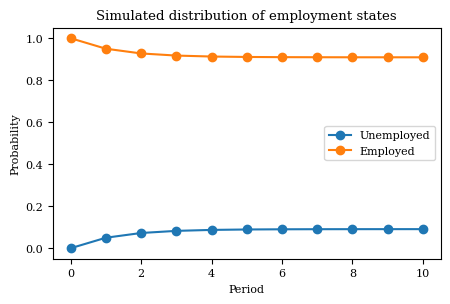

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(sequence, marker='o')
plt.legend(['Unemployed', 'Employed'])
plt.xlabel('Period')
plt.ylabel('Probability')
plt.title('Simulated distribution of employment states')

As you see, these fractions seem to converge to some fixed values, which suggests that this is the stationary distribution over employment states. It moreover suggests that one way to compute the stationary distribution is to apply the law-of-motion [(1)](#markov:LOM) until $\bm\mu$ no longer changes. There is an additional shortcut: we can iterate on [(1)](#markov:LOM) to see that the distribution after two periods is
$$
\bm\mu_{t+2} = \bm\mu_t \bm\Pi^2
$$
or in general, after $N$ periods,
$$
\bm\mu_{t+N} = \bm\mu_t \bm\Pi^N
$$
where $\bm\Pi^N$ is the matrix power operation (multiplying $\bm\Pi$ by itself $N$ times), *not* elementwise exponentiation. One way to compute the ergodic distribution is therefore 
$$
\bm\mu^* = \mu_0 \bm\Pi^N
$$
for some initial distribution $\bm\mu_0$ and some sufficiently large $N$.

For our employment state example, this yields the following:

In [8]:
# Compute the invariant distribution
N = 1000
mu0 = np.array((0.0, 1.0))
mu_inv = mu0 @ np.linalg.matrix_power(Pi, N)

# Print the invariant distribution
mu_inv

array([0.09090909, 0.90909091])

In the long run, we therefore expect 9.09% of individuals to be unemployed. This is in line with the graph we generated earlier, reproduced below:

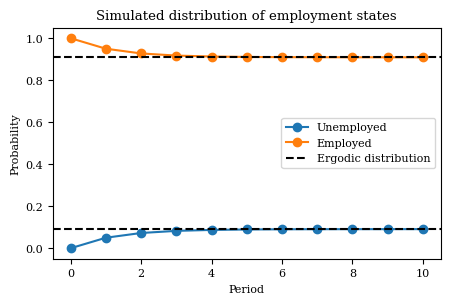

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(sequence, marker='o')
plt.xlabel('Period')
plt.ylabel('Probability')
plt.title('Simulated distribution of employment states')
# Add horizontal lines indicating the invariant distribution
plt.axhline(mu_inv[0], color='black', linestyle='--')
plt.axhline(mu_inv[1], color='black', linestyle='--')
plt.legend(['Unemployed', 'Employed', 'Ergodic distribution'])

### Approximating AR(1) processes as Markov chains

You might have noticed that the AR(1) process we studied in the previous lecture shares some properties with the Markov chains studied here:

-   In both cases, once conditioning on the realization $x_t$, earlier realizations in $t-1$, $t-2$, $\dots$, provide no additional information about $x_{t+1}$.
-   Both stochastic processes can be used to model serial correlation, i.e., interdependence of two consecutive observations.

On the other hand, the AR(1) is usually allowed to take on values on the real line $\mathbb{R}$, whereas the Markov chains studied here were restricted to a finite state space of $n$ elements. While this is restrictive, it makes working with Markov chains much easier, in particular in numerical applications since computers by construction operate on sets of finite values. 

This leads to the question whether AR(1) processes can be sufficiently well approximated by Markov chains. This is indeed the case, 
and several competing methods have been developed to perform this approximation, e.g., [Tauchen 1986](https://www.sciencedirect.com/science/article/abs/pii/0165176586901680)
and [Rouwenhorst 1995](https://www.degruyter.com/document/doi/10.1515/9780691218052-014/pdf?licenseType=restricted).

In the remainder of this section, we compare an AR(1) to its Markov chain approximation created with the Rouwenhorst method.


We use the `rouwenhorst()` function defined in `markov.py` to create the approximation. The method takes the AR(1) parameters and the desired number of states as arguments and returns the discretized state space and Markov transition matrix.

In [10]:
from markov import rouwenhorst

# Parameters of AR(1) process:
# Autoregressive parameter
rho = 0.9
# Conditional standard deviation
sigma = 0.1
# AR(1) intercept
mu = 0

# Number of points on discretized state space
N = 11

# Compute state space and transition matrix of Markov chain
states, Pi = rouwenhorst(N, mu, rho, sigma)

With the transition matrix `Pi` in hand, we can call our simulation function we wrote earlier to simulate a sequence of $T=500$ realizations (recall that the function returns the *indices*, not the states themselves).

In [11]:
# Number of periods to simulate
T = 500

# Initial state index: start at midpoint of state space
i0 = N // 2

# Simulate the Markov chain, return sequence of indices
markov_sim_indices = simulate_sequence(i0, Pi, T)

In [12]:
# Recover states from indices
markov_sim = states[markov_sim_indices]

To compare the simulated Markov chain so the original AR(1), we use the following function to simulate an AR(1).

In [13]:
def simulate_ar1(x0, mu, rho, sigma, T, rng=None):
    """
    Simulates an AR(1) process.

    Parameters
    ----------
    x0 : float
        The initial value of the process.
    mu : float
        Intercept.
    rho : float
        The autoregressive parameter.
    sigma : float
        The standard deviation of the noise term.
    T : int
        The number of time periods to simulate.
    rng : Generator, optional
        Random number generator to use.

    Returns
    -------
    numpy.ndarray
        An array of length `n` containing the simulated AR(1) process.
    """

    # Initialize the random number generator
    if rng is None:
        rng = np.random.default_rng(seed=123)

    # Create an array to store the simulated values
    x = np.zeros(T+1)

    # Set the initial value
    x[0] = x0
        
    # Draw random shocks
    eps = rng.normal(0, sigma, T)

    # Simulate the AR(1) process
    for t in range(T):
        x[t+1] = mu + rho * x[t] + eps[t]

    return x

In [14]:
# Initial value: start at unconditional mean
x0 = mu / (1 - rho)

# Simulate AR(1)
ar1_sim = simulate_ar1(0, mu, rho, sigma, T)

The following code plots the simulated AR(1) process and the Markov chain:

Text(0.5, 1.0, 'Markov chain')

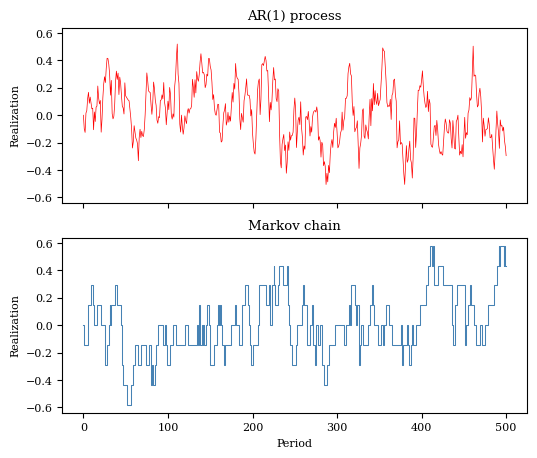

In [15]:
import matplotlib.pyplot as plt

periods = np.arange(T+1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True, sharey=True)
ax1.plot(periods, ar1_sim, color='red', ls='-', lw=0.5, label='AR(1)')
ax1.set_title('AR(1) process')
ax1.set_ylabel('Realization')
ax2.step(periods, markov_sim, color='steelblue', lw=0.75, label='Markov chain')
ax2.set_xlabel('Period')
ax2.set_ylabel('Realization')
ax2.set_title('Markov chain')

Note that these sequences need *not* look the same, even when using an RNG with same seed, as the random draws influence these realizations in a different fashion. Instead, we are interested in whether the Markov chain approximation generates moments which are similar to the AR(1) and their theoretical counterparts. The following code computes these moments (autocorrelation, conditional and unconditional standard deviation).

In [16]:
# Autocorrelation
rho_ar1 = np.corrcoef(ar1_sim[:-1], ar1_sim[1:])[0, 1]
rho_mc = np.corrcoef(markov_sim[:-1], markov_sim[1:])[0, 1]

# Unconditional standard deviation
std_uncond_ar1 = np.std(ar1_sim)
std_uncond_mc = np.std(markov_sim)

# Conditional standard deviation
std_cond_ar1 = np.std(ar1_sim[1:] - rho*ar1_sim[:-1])
std_cond_mc = np.std(markov_sim[1:] - markov_sim[:-1])

We use a pandas `DataFrame` to quickly generate a table that allows us to compare the values. We will study pandas in later lectures, so at the moment you can ignore the code that generates the table and focus on the output.

In [17]:
import pandas as pd

# Create a DataFrame to tabulate the moments
df = pd.DataFrame(
    {
        "True": [rho, sigma / np.sqrt(1 - rho**2), sigma],
        "AR(1)": [rho_ar1, std_uncond_ar1, std_cond_ar1],
        "Markov": [rho_mc, std_uncond_mc, std_cond_mc],
    },
    index=["Autocorrelation", "Unconditional std.", "Conditional std."],
)

# Tabulate moments
print(df.to_string(float_format=lambda x: f'{x:.3f}'))

                    True  AR(1)  Markov
Autocorrelation    0.900  0.871   0.899
Unconditional std. 0.229  0.201   0.225
Conditional std.   0.100  0.099   0.101


As the table shows, all three moments are very close to their true values for both the AR(1) and the Markov chain. We conclude that the Rouwenhorst approximation with $N=11$ grid points does a good job replicating the moments of the AR(1). The quality of this approximation will of course diminish with fewer grid points.

## Asset pricing of Lucas trees

In this section, we study how Markov chains can be incorporated into an economics/finance model. The exposition is based on 
the famous [Lucas 1978](https://www.jstor.org/stable/1913837) paper by Nobel Laureate Robert E. Lucas, a seminal contribution
to the literate on consumption-based asset pricing.

This example demonstrates how we can price risky assets in a rather simply general equilibrium economy. The building blocks of the economy are as follows:

-   The economy is populated by identical household which are initially endowed with one unit of the risky asset.
-   This risky asset can be though of as a tree (hence the name "Lucas tree") with each period $t$ produces as random amount of fruit $d_t$ ("dividend") that can be consumed. Fruit is non-storable and perishes at the end of the period.
-   Households can trade claims to these trees.
-   The object of interest is the endogenous price of a tree $p_t$ that obtains in equilibrium.

### Motivating three-period example

In the canonical Lucas tree economy, household are infinitely lived (it is therefore better to think of them as dynasties).
We haven't covered infinite-horizon optimization problems in this course and will therefore start with a simpler setting with only three periods
to demonstrate how to derive the household's optimality conditions. These will turn out to be identical in the full model.

Consider a an economy which lasts for only three periods. A representative household solves the problem
$$
\begin{aligned}
\max_{c_1,~c_2,~c_3,~s_2,~s_3} \enskip& \Bigl\{ u(c_1) 
    + \beta \mathbb{E}\bigl[u(c_2)\bigr] 
    + \beta^2 \mathbb{E}\bigl[u(c_3)\bigr] \Bigr\} \\
    c_1 + p_1 s_2 &= (p_1 + d_1) s_1 \\
    c_2 + p_2 s_3 &= (p_2 + d_2) s_2 \\
        c_3 &= (p_3 + d_3) s_3
\end{aligned}
$$
by choosing consumption $c_t$ in each period and the number of shares $s_t$ of the Lucas tree to purchase in the first and second periods
(we denote the number of shares chosen in period 1 as $s_2$ as these shares will become a state variable in period 2).
The last three equations represent the budget constraints in periods 1, 2, and 3, respectively.
The household is initially endowed with $s_1$ shares.

The parameter $\beta$ denotes the discount factor applied to utility received in later periods.


#### Optimality conditions

In a first step, we use the three budget constraints to substitute out $c_1$, $c_2$, and $c_3$ so that we are left with
a problem with only two choice variables, $s_2$ and $s_3$:
$$
\max_{s_2,~s_3} \enskip \biggl\{ u\Bigl(\underbrace{(p_1 + d_1) s_1 - p_1 s_2}_{=c_1} \Bigr) 
    + \beta \mathbb{E}\Bigl[u\Bigl(\underbrace{(p_2 + d_2) s_2 - p_2 s_3}_{=c_2}\Bigr)\Bigr] 
    + \beta^2 \mathbb{E}\Bigl[u\Bigl(\underbrace{(p_3 + d_3) s_3}_{=c_3}\Bigr)\Bigr] 
    \biggr\}
$$
The first-order conditions with respect to $s_2$ is then obtained by taking the derivate of this expression with respect to $s_2$:
$$
- u'\Bigl((p_1 + d_1) s_1 - p_1 s_2 \Bigr)p_1
    + \beta \mathbb{E}\left[(p_2 + d_2) u'\Bigl((p_2 + d_2) s_2 - p_2 s_3\Bigr)\right] = 0
$$
Plugging back in the budget constraints for the first two periods, we obtain 
the Euler equation that links consumption in periods 1 and 2:
$$
u'(c_1)p_1 = \beta \mathbb{E}\Bigl[(p_2 + d_2) u'(c_2)\Bigr]
$$

Note that this Euler equation is in fact very similar to what we found in the
two-period consumption-savings problems studied in earlier lectures.
To see this, divide by $p_1$ to obtain
$$
u'(c_1) = \beta \mathbb{E}\biggl[
    \underbrace{\frac{(p_2 + d_2)}{p_1}}_{=R_{2}} u'(c_2)\biggr]
$$
where the gross return on the Lucas tree is given by $R_{t+1} = \frac{p_{t+1} + d_{t+1}}{p_t}$.
This looks almost identical to the Euler equations we encountered in earlier lectures,
$u'(c_1) = \beta R u'(c_2)$, 
except that the return is now stochastic and next-period consumption is uncertain.

### Infinite-horizon economy

We now turn to the infinite-horizon version of the household problem. This is obtained by appending additional discounted future utilities to the objective function and adding a budget constraint for each period in the future:
$$
\begin{aligned}
\max_{\{c_t,s_{t+1}\}_{t=0}^\infty} &\enskip 
    \mathbb{E}\left[\sum_{t=0}^\infty \beta^t u(c_t)\right] \\
    c_t + p_t s_{t+1} &= (p_t + d_t) s_t \qquad \text{for all } t
\end{aligned}
$$

#### Optimality conditions

The first-order conditions for this problem are very similar in nature to the three-period case. Let $\lambda_t$ be the Lagrange multiplier on the budget constraint in period $t$. Then the first-order conditions are given by
$$
\begin{aligned}
\beta^t u'(c_t) &= \lambda_t & \text{for all } t\\
\lambda_t p_t &= \mathbb{E}\Bigl[\lambda_{t+1}(p_{t+1} + d_{t+1}) \Bigl] 
    & \text{for all } t
\end{aligned}
$$
We use the first line evaluated in periods $t$ as well as $t+1$ to substitute out $\lambda_t$ and $\lambda_{t+1}$ to arrive at the Euler equation
$$
u'(c_t) p_t = \beta \mathbb{E} \Bigl[(p_{t+1} + d_{t+1}) u'(c_{t+1}) \Bigr]
$$
Note that this exactly the same condition as we derived for $t=1$ in the three-period case, but in the infinite-horizon problem it has to hold in each period.

### Dividends as a Markov process

In order to price the Lucas tree, we need to make additional assumptions about the stochastic process of dividends $d_t$. To make things simple, we assume that log dividends follow an AR(1),
$$
\log d_{t+1} = \mu + \rho \log d_t + \epsilon_{t+1}\,, \qquad 
    \epsilon_{t+1} \stackrel{\text{iid}}{\sim} \mathcal{N}(0, \sigma^2)
$$

For the numerical implementation, we discretize this AR(1) to a 2-state Markov chain with state space $(d_{lo}, d_{hi})$
and a transition matrix $\Pi$ where the element $(i, j)$ represents the probability of transitioning to dividend $d_j$ next period
if the dividend is currently $d_i$: 
$$
\Pi_{ij} = \text{Prob}\bigl(d_{t+1} = d_j~|~d_t = d_i \bigr)
$$

Since the Markov chain has only two possible states, the equilibrium will consistent of two different prices $p_{lo}$ and $p_{hi}$ corresponding
to the states $d_{lo}$ and $d_{hi}$, respectively. 

### Equilibrium

We assume that the economy is populated by a continuum of identical households  who are initially endowed with one Lucas tree, $s_0 = 1$. Without loss of generality, we can equivalently impose that there is a single representative household who takes prices as given. 

- Because all households are identical, there can be no trade in equilibrium and thus a household will continue to hold the initial Lucas tree so that $s_t = 1$ for all $t$.
- In the absence of trade, the representative household has to consume the dividend (non-storable fruit) each period, so that $c_t = d_t$
    for all $t$.
- For this allocation to be an equilibrium, the price of the Lucas tree $p_t$ has to be set so that the household's optimality conditions are satisfied, i.e., the household
    has no desire to deviate from this no-trade allocation.

Since we have assumed that dividends take on only two different values and the economy has no other state variable (as nothing can be stored), the equilibrium prices have to satisfy the optimality conditions evaluated at the equilibrium allocation for each dividend state:
<a id="Lucas:eq"></a>
$$
\tag{2} 
\begin{aligned}
\text{Low dividend today:} \quad &
u'(d_{lo}) p_{lo} = \beta \mathbb{E} \Bigl[\Bigl. (p_{t+1} + d_{t+1}) u'(d_{t+1}) ~\Bigr|~ d_t = d_{lo} \Bigr] \\
\text{High dividend today:} \quad &
u'(d_{hi}) p_{hi} = \beta \mathbb{E} \Bigl[\Bigl. (p_{t+1} + d_{t+1}) u'(d_{t+1}) ~\Bigr|~ d_t = d_{hi} \Bigr]
\end{aligned}
$$
where we have substituted $d_t = c_t$ for the low and high dividend states.
Note that the expectations on the right-hand side differ only in what they condition on: since dividends are autocorrelated, 
expected next-period dividends differ depending on whether dividends today are low or high.

So far we didn't need to specify preferences for the derivations above (other than the usual conditions imposed on the utility function). For the numerical implementation, we need to be more concrete, so we make the usual assumption of CRRA preferences,
$$
u(c) = \begin{cases}
    \frac{c^{1-\gamma}}{1-\gamma} & \text{if } \gamma \neq 1 \\
    \log(c) & \text{if } \gamma = 1
    \end{cases}
$$ 
The equilibrium conditions pinning down prices then become
$$
\begin{aligned}
d_{lo}^{-\gamma} p_{lo} = \beta \mathbb{E} \Bigl[\Bigl. (p_{t+1} + d_{t+1}) d_{t+1}^{-\gamma} ~\Bigr|~ d_t = d_{lo} \Bigr] \\
d_{hi}^{-\gamma} p_{hi} = \beta \mathbb{E} \Bigl[\Bigl. (p_{t+1} + d_{t+1}) d_{t+1}^{-\gamma} ~\Bigr|~ d_t = d_{hi} \Bigr]
\end{aligned}
$$
This is a system of two equations in two unknowns which can be solved numerically.

### Numerical solution

#### Parameters

We normalize the average dividend to be 1, which can be achieved by imposing the following value for $\mu$:
Recall from the previous lecture that the stationary distribution
of the AR(1) is given by 
$$
\log d_t \sim \mathcal{N}\left( \frac{\mu}{1-\rho}, ~\frac{\sigma^2}{1-\rho^2} \right)
$$
From the formula for the mean of a log-normal variable, we obtain the unconditional mean of dividends as
$$
\mathbb{E}[d_t] = \exp\left\{ \frac{\mu}{1-\rho} + \frac{1}{2} \frac{\sigma^2}{1-\rho^2}\right\}
$$
In order to impose $\mathbb{E}[d_t] = 1$, we need to set 
$\mu = -\frac{1}{2}\frac{\sigma^2}{1+\rho}$, as then
$$
\begin{aligned}
\mathbb{E}[d_t] = \exp\left\{ -\frac{1}{2}\frac{\sigma^2}{1-\rho^2} + \frac{1}{2} \frac{\sigma^2}{1-\rho^2}\right\} = e^0 = 1
\end{aligned}
$$

We set the remaining parameters as follows:

| Parameter  | Description | Value       |
|------------|-------------|-------------|
| $\sigma$ | Volatility of log dividends | 0.1 |
| $\rho$  | Autocorrelation of log dividends | 0.5 |
| $\mu$ | Intercept of log dividends | $-\frac{1}{2}\frac{\sigma^2}{1+\rho}$|
| $\beta$ | Discount factor | 0.96 |
| $\gamma$ | Relative risk aversion | 2 |


The following `Parameters` data class defines these parameter values.

In [18]:
from dataclasses import dataclass

@dataclass
class Parameters:
    sigma: float = 0.1          # Volatility of log dividends
    rho: float = 0.5            # Autocorrelation of log dividends
    mu: float = -sigma**2/2/(1+rho)     # Intercept of log dividends
    beta: float = 0.96          # Discount factor
    gamma: float = 2            # Relative risk aversion

In [19]:
# Create instance of parameter class
par = Parameters()

#### Markov chain

As in the previous section, we use the `rouwenhorst()` function to discretize the AR(1) into a Markov chain. We create a convenience function to do this because we need to ensure that the unconditional mean of the discretized dividend process is exactly one (while this would hold exactly for the AR(1) given the chosen value of $\mu$, it holds only approximately for the Markov chain).

In [20]:
from markov import rouwenhorst, markov_ergodic_dist
import numpy as np


def create_markov(N, mu, rho, sigma):
    """
    Create a Markov chain approximation of an AR(1) process and ensure
    that the unconditional mean is 1.

    Parameters
    ----------
    N : int
        Number of points on the discretized state space.
    mu : float
        Intercept of the AR(1) process.
    rho : float
        Autocorrelation coefficient of the AR(1) process.
    sigma : float
        Standard deviation of the noise term in the AR(1) process.

    Returns
    -------
    dividends : numpy.ndarray
        Discretized state space in levels, normalized to have an unconditional mean of 1.
    Pi : numpy.ndarray
        Transition matrix of the Markov chain.
    """
    # Get log dividends and transition matrix
    states, Pi = rouwenhorst(N, mu, rho, sigma)

    # State space in levels
    dividends = np.exp(states)

    # Compute stationary distribution
    dist = markov_ergodic_dist(Pi)

    # Compute unconditional mean of dividends
    mean_dividends = np.sum(dist * dividends)

    # Normalize dividends to have unconditional mean of 1
    dividends /= mean_dividends

    # Check that unconditional mean is 1
    assert np.isclose(np.sum(dist * dividends), 1)

    return dividends, Pi


Note that we used the function `markov_ergodic_dist` defined in the file `markov.py` to compute the ergodic distribution of dividend states. This ergodic distribution is required to compute the unconditional mean of dividends.

We can now create discretized approximation using $N=2$ states:

In [21]:
# Number of points on the discretized state space
N = 2

# Create Markov chain state space and transition matrix
dividends, Pi = create_markov(N, par.mu, par.rho, par.sigma)

#### Root-finder

With the Markov chain approximation in hand, we implement a function that evaluates the first-order conditions
[(2)](#Lucas:eq) and returns the Euler equation errors, i.e., the left-hand side minus the right-hand side.
This function will be repeatedly called by the root-finder with various candidate equilibrium price vectors.

In [22]:
def foc_error(p, par, d, Pi):
    """
    Evaluate the first-order conditions for the Lucas tree model.

    Parameters
    ----------
    p : numpy.ndarray
        Candidate price vector.
    par : Parameters
        Model parameters.
    d : numpy.ndarray
        Vector of dividends.
    Pi : numpy.ndarray
        Transition matrix of the Markov chain.

    Returns
    -------
    numpy.ndarray
        Euler equation errors.
    """

    # LHS of Euler equations:
    # Marginal utility today * candidate price vector
    lhs = d ** -par.gamma * p

    # RHS of Euler equations:
    rhs = par.beta * Pi @ ((p + d) * d**-par.gamma)

    # Euler equation errors
    err = lhs - rhs

    return err

With the `foc_error()` function in place, we use the multidimensional root-finder
[root()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html)
from the `scipy.optimize` package to find the equilibrium price vectors which satisfies the household optimality conditions.

In [23]:
from scipy.optimize import root

# Additional arguments for the FOC error function
args = par, dividends, Pi

# Initial guess for equilibrium price vector
p0 = np.ones_like(dividends)

# Find equilibrium price vector
res = root(foc_error, method='hybr', x0=dividends, args=args)

As usual, it is advantageous to inspect the result object returned by the root-finder to verify that the algorithm terminated successfully, which is the case here.

In [24]:
# Print attributes of the result object
res

 message: The solution converged.
 success: True
  status: 1
     fun: [ 3.553e-15  0.000e+00]
       x: [ 1.914e+01  3.010e+01]
  method: hybr
    nfev: 16
    fjac: [[-9.022e-01  4.314e-01]
           [-4.314e-01 -9.022e-01]]
       r: [-4.568e-01  2.702e-01 -1.859e-01]
     qtf: [-3.205e-15 -1.533e-15]

Next, we store and print the equilibrium price vector.

In [25]:
# Store the equilibrium price vector
prices = res.x
prices

array([19.13512208, 30.10112697])

As you can see, the price of the Lucas tree is substantially higher in the high dividend state. The reason is that even though dividends are positively correlated, the correlation is not perfect and thus there is a chance that dividends (and thus consumption) will be lower tomorrow. The risk-averse households would want to smooth consumption across periods by saving more today, i.e., by increasing its holdings of the risky asset. Since there is no trade in equilibrium, this saving motive has to be neutralized by making saving sufficiently unattractive. In equilibrium, this is achieved by making the risky asset more expensive.

We can see this more explicitly by computing the expected net return $r_i$ for each state $i$,
$$
r_i = \mathbb{E}\left[\left.\frac{p_{t+1} + d_{t+1}}{p_t} \right| d_t = d_i \right] - 1 \qquad i \in \{lo, hi\}
$$
which can be computed using the following expression:


In [26]:
# Expected net return
(Pi @ (prices + dividends)) / prices - 1

array([ 0.19252668, -0.05594546])

As you can see, the expected net return is in fact negative when dividends are high in order to discourage households from saving.

The opposite logic applies if dividends are low today. In expectations, dividends (and thus consumption) will be higher tomorrow, so the consumption-smoothing household would want to borrow today (i.e., *sell* shares of the Lucas tree) to finance higher consumption today. In equilibrium this is not possible, so the equilibrium $p_{lo}$ has to adjust downward to make this unattractive.

### Comparative statics

In the last part, we examine how equilibrium prices respond to changes in parameters.

#### Relative risk aversion

First, we study how prices change as a function of risk aversion. To this end, we compute the equilibrium for a grid of values for the relative risk aversion $\gamma$.

In [27]:
# Grid of RRAs for which to compute equilibrium prices
gamma_grid = np.linspace(1, 10, 100)

# Create an array to store equilibrium prices
prices_grid = np.empty((len(gamma_grid), len(dividends)))

# Loop over the grid of RRAs, compute equilibrium prices
for i, gamma in enumerate(gamma_grid):
    par = Parameters(gamma=gamma)
    res = root(foc_error, method='hybr', x0=dividends, args=(par, dividends, Pi))
    prices_grid[i] = res.x
    

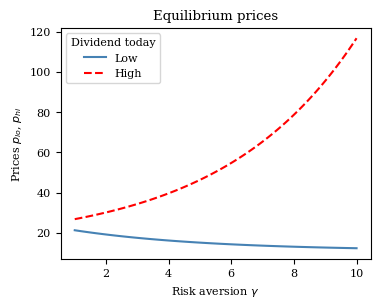

In [28]:
import matplotlib.pyplot as plt

plt.plot(gamma_grid, prices_grid[:, 0], c='steelblue', label='Low')
plt.plot(gamma_grid, prices_grid[:, 1], c='red', ls='--', label='High')
plt.xlabel(r'Risk aversion $\gamma$')
plt.ylabel('Prices $p_{lo}$, $p_{hi}$')
plt.title('Equilibrium prices')
plt.legend(title='Dividend today')

The graph shows that the price of the risky asset *increases* with risk aversion in the high dividend state. This might seem counterintuitive, as you might think that households want to hold fewer the risky assets as they become more risk averse, but this logic only holds if there is a risk-free asset in the economy which is not the case here. 

In this setting, as households become more risk averse, they have a stronger precautionary savings motive and want to insure against a possible drop in consumption tomorrow when dividends are high today, so their demand for holding assets (even risky ones) *increases*. To counteract this and maintain the no-trade equilibrium, the price $p_{hi}$ has to increase so that the return on the risky asset drops.

#### Discount factor

We repeat the exercise but now vary the discount factor $\beta$:

In [29]:
# Grid of discount factors for which to compute equilibrium prices
beta_grid = np.linspace(0.8, 0.99, 100)

# Create an array to store equilibrium prices
prices_grid = np.empty((len(beta_grid), len(dividends)))

# Loop over the grid of discount factors, compute equilibrium prices
for i, beta in enumerate(beta_grid):
    par = Parameters(beta=beta)
    res = root(foc_error, method='hybr', x0=dividends, args=(par, dividends, Pi))
    prices_grid[i] = res.x

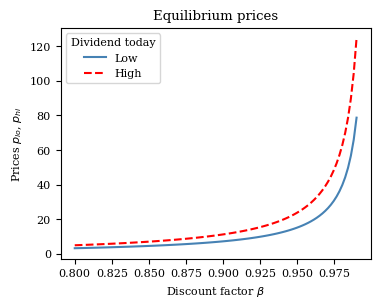

In [30]:
import matplotlib.pyplot as plt

plt.plot(beta_grid, prices_grid[:, 0], c='steelblue', label='Low')
plt.plot(beta_grid, prices_grid[:, 1], c='red', ls='--', label='High')
plt.xlabel(r'Discount factor $\beta$')
plt.ylabel('Prices $p_{lo}$, $p_{hi}$')
plt.title('Equilibrium prices')
plt.legend(title='Dividend today')


The graph shows that increases in the discount factor affect asset prices in both states symmetrically. As households become more patient, they want to increase their savings by purchasing more shares of the risky asset. To support the no-trade equilibrium, asset prices in both states therefore have to increase.

#### Volatility of dividends

Finally, we vary the parameter $\sigma$ controlling the volatility of dividends.

In [31]:
# Grid of sigma for which to compute equilibrium prices
sigma_grid = np.linspace(0.001, 0.5, 100)

# Create an array to store equilibrium prices
prices_grid = np.empty((len(sigma_grid), len(dividends)))

# Loop over the grid of sigma, compute equilibrium prices
for i, sigma in enumerate(sigma_grid):
    
    par = Parameters(sigma=sigma)

    # Recreate discretized state space and transition matrix
    dividends, Pi = create_markov(N, par.mu, par.rho, par.sigma)

    res = root(foc_error, method='hybr', x0=dividends, args=(par, dividends, Pi))
    prices_grid[i] = res.x

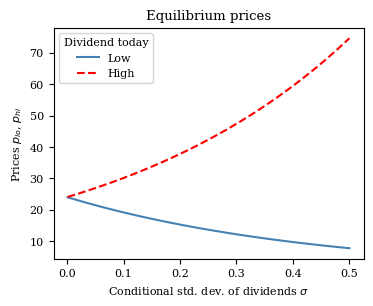

In [32]:
import matplotlib.pyplot as plt

plt.plot(sigma_grid, prices_grid[:, 0], c='steelblue', label='Low')
plt.plot(sigma_grid, prices_grid[:, 1], c='red', ls='--', label='High')
plt.xlabel(r'Conditional std. dev. of dividends $\sigma$')
plt.ylabel('Prices $p_{lo}$, $p_{hi}$')
plt.title('Equilibrium prices')
plt.legend(title='Dividend today')


The effect of increasing the volatility of dividends is more or less the same as that of increasing the risk aversion. More risky dividends induce a higher demand for precautionary savings, so the price in the high-dividend state has to increase to counteract this additional savings motive.